In [1]:
# import numpy
%pylab inline
# cd the working directory
!cd /share/lamost/dr7/slam_tutorial/

Populating the interactive namespace from numpy and matplotlib


In [2]:
# read parameters
from astropy.table import Table
params = Table.read("./params.fits")

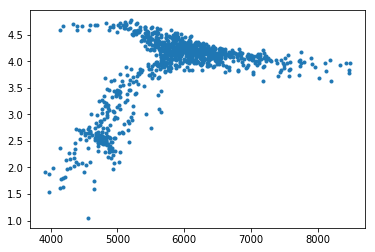

In [3]:
# take a look at the parameters
plot(params["teff"], params["logg"],'.')

In [4]:
# check filepath
import os
for i in range(len(params)):
    if not os.path.exists("./spectra/"+params[i]["fps"]):
        print(i)

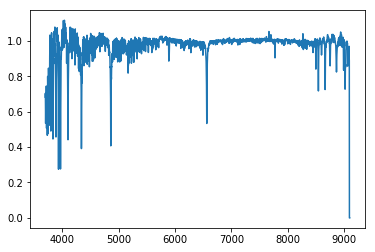

In [5]:
# an example of reading spectra
from laspec.mrs import MrsSpec
ms = MrsSpec.from_lrs("./spectra/"+params["fps"][149], deg=10)
# fig = figure(figsize=(15, 7))
ms.plot_norm()

In [6]:
# define wavelength grid
wave = np.arange(4000, 5500, 1.)
npix = len(wave)
nobs = len(params)

In [7]:
# import joblib
# # read spectra
# ms_list = joblib.Parallel(n_jobs=-1, verbose=10)(
#     joblib.delayed(MrsSpec.from_lrs)("./spectra/"+params["fps"][i], deg=10) for i in range(nobs))
# # save spectra
# joblib.dump(ms_list, "ms_list.dump")

In [8]:
# load spectra
import joblib
ms_list = joblib.load("ms_list.dump")

flux_norm = np.array([np.interp(wave, ms.wave, ms.flux_norm) for ms in ms_list])
ivar_norm = np.array([np.interp(wave, ms.wave, ms.flux_norm_err**-2) for ms in ms_list])

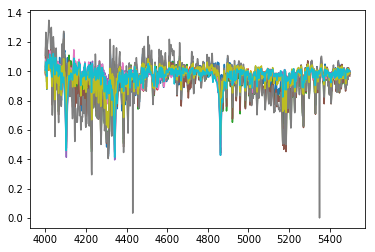

In [9]:
# take a look at spectra
plot(wave, flux_norm[::100].T)

In [10]:
# initiate slam
from slam import Slam
s = Slam(wave, # wavelength grid
         tr_flux=flux_norm, # training flux
         tr_ivar=ivar_norm, # training ivar
         tr_labels=np.array(params["teff","logg", "feh"].to_pandas()), # training labels
         scale=True, # if True, scale flux and labels. default is True
         robust=False, # if True, use robust scaling. default is True --> this is to tackle the cosmic rays
         mask_conv=(1, 2), # lower and upper limits of the kernel used in convolution
         flux_bounds=(0.001, 100.0), # flux bounds. 
         ivar_eps=0, # slam will eliminate the pixels whose ivar<ivar_eps
        )

/home/cham/anaconda3/lib/python3.7/site-packages/slam/slam3.py:1696: RuntimeWarning: invalid value encountered in greater
  ind_ivar_valid = ivar > ivar_eps


@Slam.heal_the_world: IVAR of 122 spectra need to be reset
(2, 8), (3, 16), (22, 7), (33, 17), (34, 36), (40, 180), (42, 6), (46, 8), (49, 10), (57, 39), (74, 8), (76, 8), (92, 7), (93, 7), (105, 7), (116, 8), (135, 9), (141, 7), (157, 22), (160, 8), (193, 70), (207, 234), (215, 7), (220, 7), (221, 40), (222, 19), (231, 58), (235, 59), (250, 8), (266, 8), (274, 7), (280, 6), (285, 7), (290, 20), (297, 367), (314, 31), (321, 36), (323, 7), (325, 8), (334, 256), (339, 30), (342, 8), (344, 8), (373, 72), (395, 184), (402, 133), (416, 8), (418, 6), (427, 162), (431, 30), (432, 149), (434, 21), (435, 14), (443, 181), (446, 7), (476, 31), (477, 28), (483, 311), (496, 119), (499, 13), (501, 22), (503, 36), (508, 7), (517, 7), (526, 390), (544, 11), (551, 9), (554, 6), (557, 8), (568, 22), (576, 92), (588, 144), (590, 7), (597, 32), (610, 15), (618, 41), (635, 20), (636, 8), (640, 7), (641, 8), (655, 21), (670, 303), (683, 8), (684, 105), (691, 8), (693, 53), (699, 507), (700, 33), (701, 17), 

In [11]:
print(s)

Slam3 instance:
tr_flux............: ( 1000 x 1500 )
tr_ivar............: ( 1000 x 1500 )
tr_labels..........: ( 1000 x 3 )
--------------------------------------
tr_flux_scaled.....: ( 1000 x 1500 )
tr_ivar_scaled.....: ( 1000 x 1500 )
tr_labels_scaled...: ( 1000 x 3 )
--------------------------------------
scale..............: True
robust.............: False
mask_conv..........: (1, 2)
flux_bounds........: (0.001, 100.0)
ivar_eps...........: 0
--------------------------------------
model..............: untrained
sms................: list[0]
scores.............: list[0]
hyper-parameters...: Table[length=0]
trained............: False
replicated.........: False


In [12]:
# train pixels
# 1. defind hyperparameter grid
pgrid = {"C":[-1,0,1],"gamma":[1/3,],"epsilon":[0.05,],}
# 2. train pixels
s.train_pixels(
    profile=None, targets='all', temp_dir=None, sample_weight_scheme='bool', # usually you can leave these unchanged
    model='svr', # model type: svr/nn
    method='grid', # simple/grid. if simple, specify hyperparameter values; if grid, specify the grid
    param_grid=pgrid, # the grid
    cv=3, # cv fold
    scoring='neg_mean_squared_error', 
    n_jobs=-1, verbose=5) # parallel

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:    9.8s


         C  gamma  epsilon
count  0.0    0.0      0.0
mean   NaN    NaN      NaN
std    NaN    NaN      NaN
min    NaN    NaN      NaN
25%    NaN    NaN      NaN
50%    NaN    NaN      NaN
75%    NaN    NaN      NaN
max    NaN    NaN      NaN


[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:   10.6s finished


In [13]:
# get initial estimate of parameters by chi2 best match
Xinit = s.predict_labels_quick(s.tr_flux, s.tr_ivar)

@Slam.heal_the_world: IVAR of 0 spectra need to be reset


@Slam.heal_the_world: FLUX of 0 spectra need to be reset



In [14]:
#optimize parameters
Rpred = s.predict_labels_multi(Xinit[::100], s.tr_flux[::100], s.tr_ivar[::100])
Xpred = np.array([_["x"] for _ in Rpred])

@Slam.heal_the_world: IVAR of 0 spectra need to be reset


@Slam.heal_the_world: FLUX of 0 spectra need to be reset

@SLAM: NMSE is not available and will be calculated now!
@SLAM: The spectra with fewest pixels unmasked is [1435/1500]
@SLAM3: nfev=55, status=2, pstd=[5.74917194 0.02414902 0.00831097]
@SLAM3: nfev=37, status=2, pstd=[6.26011286 0.0106451  0.00916556]
@SLAM3: nfev=29, status=2, pstd=[3.3878548  0.01060403 0.00741536]
@SLAM3: nfev=21, status=2, pstd=[6.47602492 0.0110048  0.00727921]
@SLAM3: nfev=21, status=2, pstd=[6.63631159 0.015807   0.0097628 ]
@SLAM3: nfev=33, status=2, pstd=[4.16613388 0.00906958 0.00623876]
@SLAM3: nfev=21, status=2, pstd=[6.87530233e+00 1.30674116e-02 6.81780244e-03]
@SLAM3: nfev=37, status=2, pstd=[7.12588952e+00 7.79774951e-03 5.51395700e-03]
@SLAM3: nfev=65, status=2, pstd=[6.64813513 0.01382337 0.01076468]
@SLAM3: nfev=33, status=2, pstd=[6.06126165 0.01283811 0.00759408]


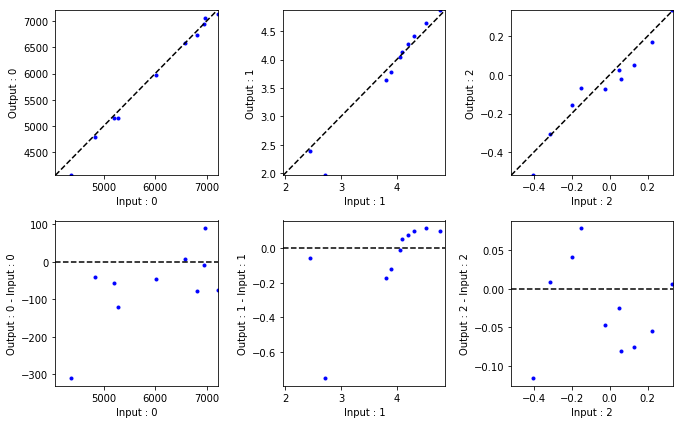

In [15]:
# compare labels
from slam.diagnostic import compare_labels
fig = compare_labels(s.tr_labels[::100], Xpred, labelname1="Input", labelname2="Output")

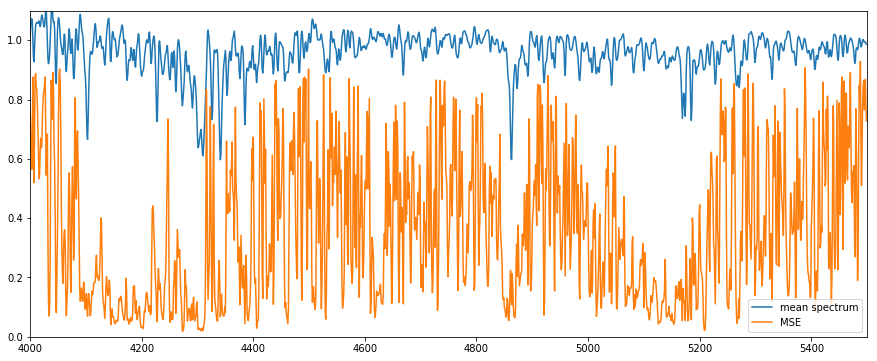

In [16]:
# check MSE (goodness of training)
fig = figure(figsize=(15, 6))
plot(s.wave, np.median(s.tr_flux, axis=0), label="mean spectrum")
plot(s.wave, -s.nmse, label="MSE")
xlim(4000, 5500)
ylim(0, 1.1)
legend()

In [17]:
# have fun with slam!